### Model Training Pipeline

This notebook retrains the model and saves the model and performance metrics (Accuracy and AUC) to the Hopsworks.ai Model Registry.

It executes Notebook 07 as part of the process and will use parameters as set there (GPU/no GPU, retune Hyperparameters or not, etc...). 

Notebook 07 is executed as a subprocess and the output is captured and displayed in this notebook. Notebook 07 is used instead of full conversion to py scripts because, while Neptune.ai experiment tracking is integrated in, I like to be able to also review the output in the notebook as well.


This Notebook does the following:
 - Retrieves a train and test dataset from the Feature Store based upon on how many DAYS back from today you want to use as the test dataset.
 - Saves theses datasets as csv files in the data directory where Notebook 07 will expect to find them.
 - Executes Notebook 07 as a subprocess and captures the output.
 - Saves the model and performance metrics to the Hopsworks.ai Model Registry.


In [1]:
import os

import pandas as pd
import numpy as np

import hopsworks

from hsml.schema import Schema
from hsml.model_schema import ModelSchema
from hsfs.client.exceptions import RestAPIError

from pathlib import Path  #for Windows/Linux compatibility
DATAPATH = Path(r'data')

import json

from datetime import datetime, timedelta

from src.hopsworks_utils import (
    convert_feature_names,
    create_train_test_data,
)

from dotenv import load_dotenv


**Parameters**

In [2]:
STARTDATE = "2003-01-01" # start date "YYYY-MM-DD" for training data, data goes back to 2003 season "2003-01-01"
DAYS = 30 # number of of most recent days to use as test data

**Connect to Hopsworks FeatureStore and Pull Train and Test data**

In [3]:
try:
    HOPSWORKS_API_KEY = os.environ['HOPSWORKS_API_KEY']
except:
    raise Exception('Set environment variable HOPSWORKS_API_KEY')

train, test = create_train_test_data(HOPSWORKS_API_KEY, STARTDATE, DAYS)

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/3350


Connected. Call `.close()` to terminate connection gracefully.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/3350/fs/3297/fv/rolling_stats_fv/version/2
Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/3350/jobs/named/rolling_stats_fv_2_1_create_fv_td_01042023170446/executions


Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/3350/jobs/named/rolling_stats_fv_2_2_create_fv_td_01042023170450/executions


In [4]:
train

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,...,FG3_PCT_AVG_LAST_10_ALL_x_minus_y,FG3_PCT_AVG_LAST_15_ALL_x_minus_y,AST_AVG_LAST_3_ALL_x_minus_y,AST_AVG_LAST_7_ALL_x_minus_y,AST_AVG_LAST_10_ALL_x_minus_y,AST_AVG_LAST_15_ALL_x_minus_y,REB_AVG_LAST_3_ALL_x_minus_y,REB_AVG_LAST_7_ALL_x_minus_y,REB_AVG_LAST_10_ALL_x_minus_y,REB_AVG_LAST_15_ALL_x_minus_y
0,2017-12-08,21700374,1610612759,1610612738,2017,105,0.468994,0.875000,0.295898,16,...,-0.044751,0.008040,-2.666667,-2.571429,-0.8,2.000000,-1.666667,0.857143,1.0,-1.066667
1,2015-12-04,21500287,1610612742,1610612745,2015,96,0.457031,0.700195,0.275879,23,...,-0.023083,-0.013387,2.666667,4.000000,2.3,0.733333,1.666667,-1.142857,-2.5,-2.133333
2,2021-12-10,22100382,1610612758,1610612766,2021,123,47.500000,76.500000,34.093750,22,...,-9.578125,-6.385417,-1.000000,-3.857143,-4.8,-5.133333,5.333333,7.285714,3.9,2.066667
3,2013-03-01,21200874,1610612756,1610612737,2012,92,0.444092,0.833008,0.455078,16,...,-0.099951,-0.097567,-2.666667,-2.285714,-4.5,-4.466667,12.000000,3.857143,4.1,2.933333
4,2005-11-30,20500210,1610612738,1610612755,2005,110,0.447998,0.784180,0.250000,24,...,0.033496,0.041073,3.333333,2.000000,2.1,2.000000,-11.333333,-3.571429,-4.1,-0.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23417,2007-01-05,20600483,1610612763,1610612738,2006,119,0.562988,0.792969,0.300049,32,...,0.049915,0.026058,11.000000,6.142857,3.6,1.400000,5.333333,-1.000000,-2.7,-3.133333
23418,2010-04-10,20901187,1610612766,1610612765,2009,99,0.538086,0.846191,0.467041,27,...,0.024640,0.004350,-0.666667,0.857143,-0.2,-2.000000,4.666667,4.857143,5.7,6.533333
23419,2009-12-20,20900395,1610612738,1610612750,2009,122,0.519043,0.829102,0.500000,34,...,0.031219,0.036332,5.000000,3.571429,4.0,4.000000,-2.333333,-7.857143,-8.0,-4.866667
23420,2010-12-10,21000334,1610612750,1610612765,2010,109,0.519043,0.817871,0.437988,21,...,0.057788,0.035010,5.000000,0.714286,2.3,1.533333,-1.333333,10.142857,6.7,6.400000


**Save data**

As a convenience to re-use the existing model training notebook, the data is saved to files first (currently <100 megabytes total)

In [5]:
train.to_csv(DATAPATH / "train_selected.csv",index=False)
test.to_csv(DATAPATH / "test_selected.csv",index=False)

**Model Training**

The existing model training notebook is re-used. It includes Neptune.ai experiment tracking for both training run and hyperparameter tuning.


XGB version: 1.6.1
LGB version: 3.3.2


Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
distutils Version classes are deprecated. Use packaging.version instead.
distutils Version classes are deprecated. Use packaging.version instead.


https://app.neptune.ai/cmunch1/nba-prediction/e/NBAP-151
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


1it [00:05,  5.34s/it]


Scores:

Accuracy Score: 0.6354322305229456
AUC Score: 0.6970439145338285
Optimal Threshold: 0.6037227


2it [00:10,  5.29s/it]


Scores:

Accuracy Score: 0.6499466382070438
AUC Score: 0.6942666897751887
Optimal Threshold: 0.55038327


3it [00:15,  5.29s/it]


Scores:

Accuracy Score: 0.6377028181041845
AUC Score: 0.6994736664101145
Optimal Threshold: 0.6068702


4it [00:20,  5.22s/it]


Scores:

Accuracy Score: 0.6131511528608027
AUC Score: 0.6815051486529204
Optimal Threshold: 0.64600444


5it [00:26,  5.24s/it]


Scores:

Accuracy Score: 0.6490179333902647
AUC Score: 0.6907230458921008
Optimal Threshold: 0.5478989

Scores:

Accuracy Score: 0.6440526001195457
AUC Score: 0.6924272003290317
Optimal Threshold: 0.5610805749893188
CPU times: total: 43.2 s
Wall time: 26.2 s
[[6022 3867]
 [4470 9063]]


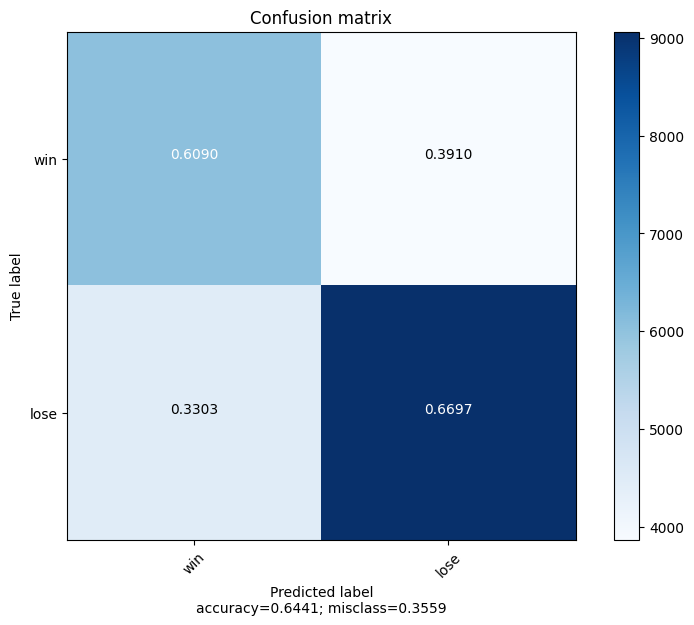

              precision    recall  f1-score   support

           0       0.57      0.61      0.59      9889
           1       0.70      0.67      0.68     13533

    accuracy                           0.64     23422
   macro avg       0.64      0.64      0.64     23422
weighted avg       0.65      0.64      0.65     23422



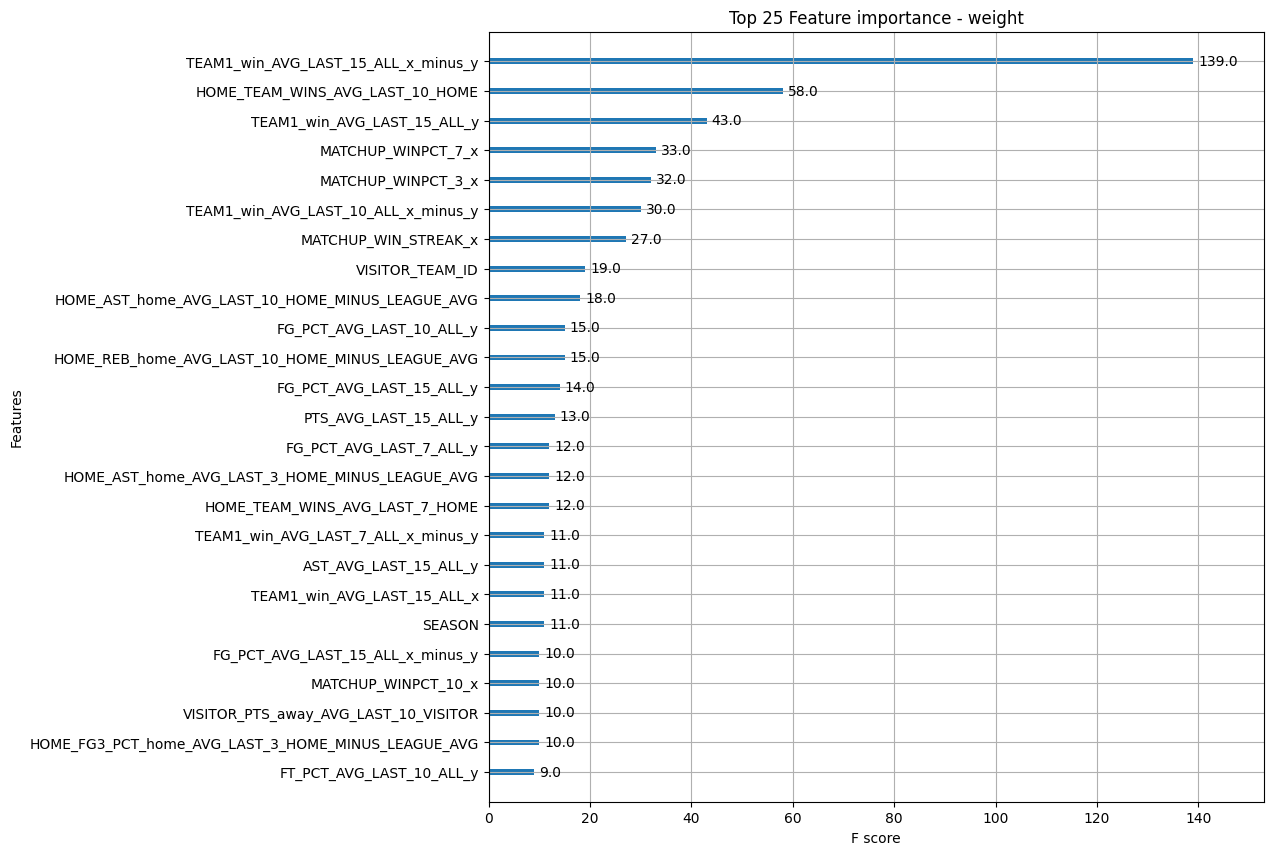

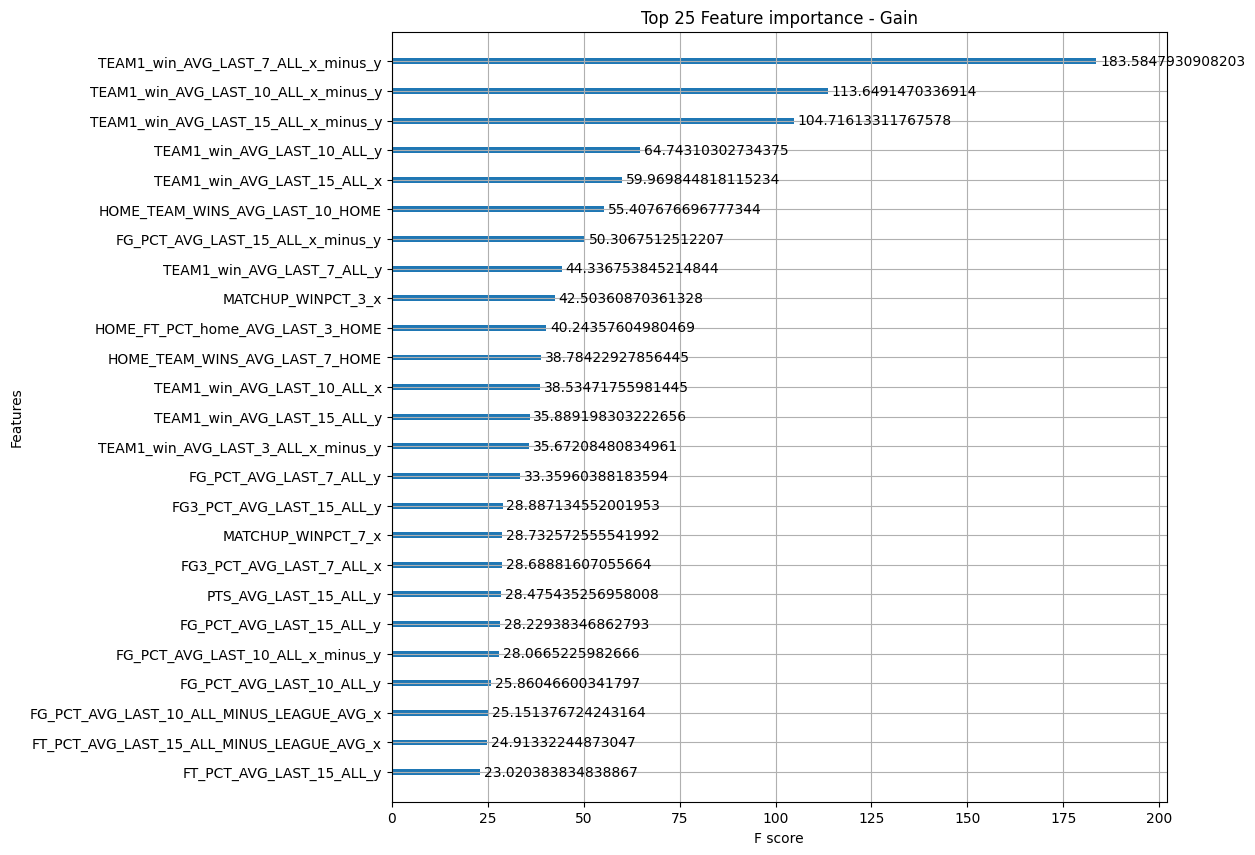

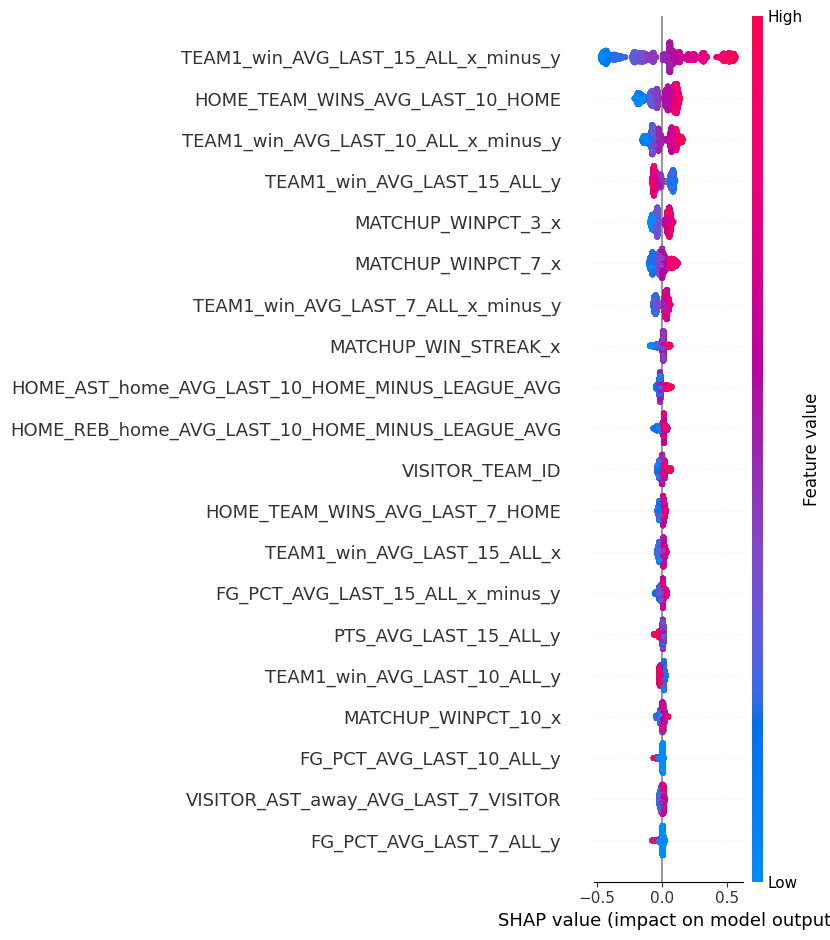

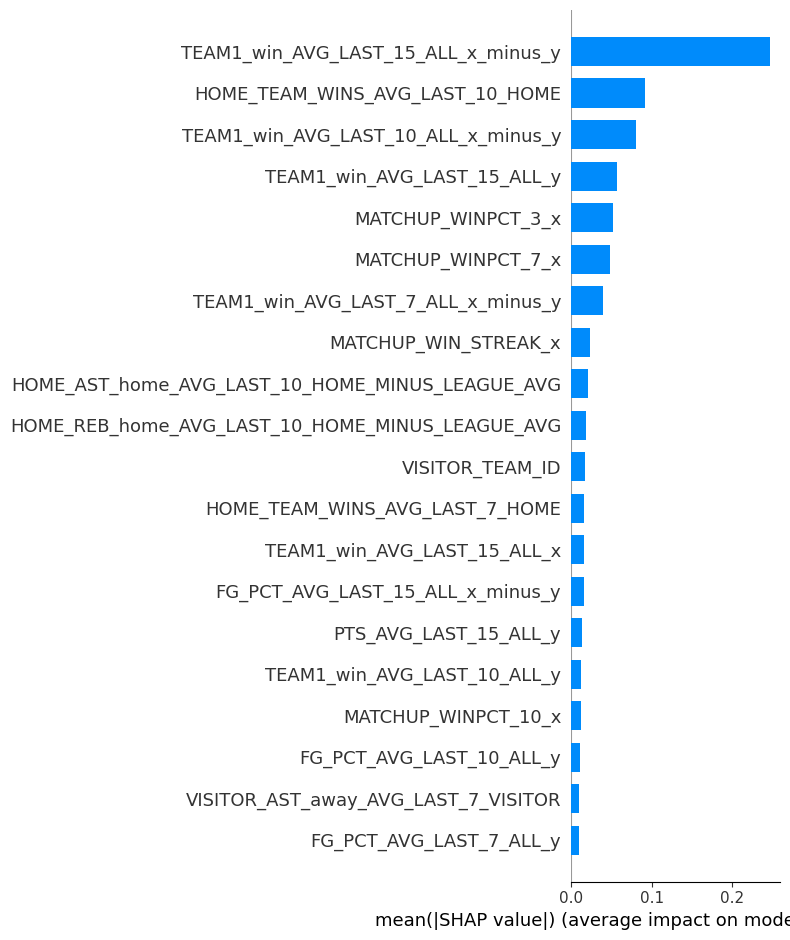


Scores:

Accuracy Score: 0.6280701754385964
AUC Score: 0.6275703324808185
Optimal Threshold: 0.4885087
[[123  47]
 [ 59  56]]


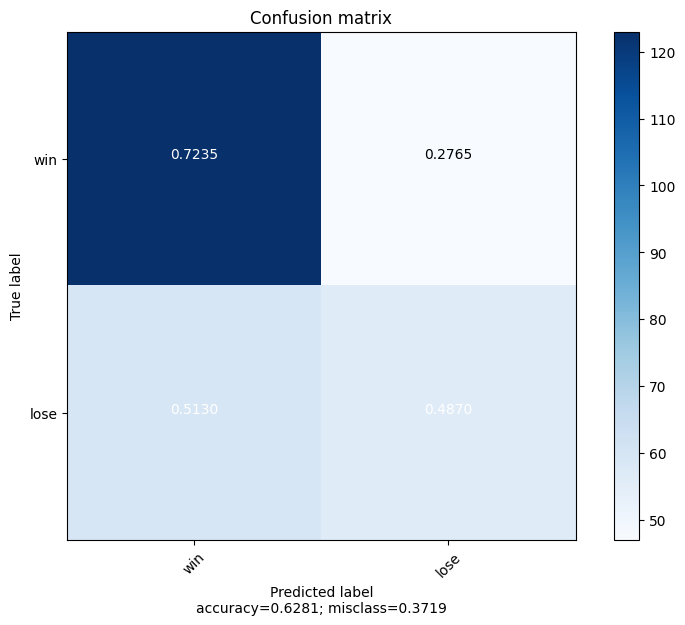

              precision    recall  f1-score   support

           0       0.68      0.72      0.70       170
           1       0.54      0.49      0.51       115

    accuracy                           0.63       285
   macro avg       0.61      0.61      0.61       285
weighted avg       0.62      0.63      0.62       285



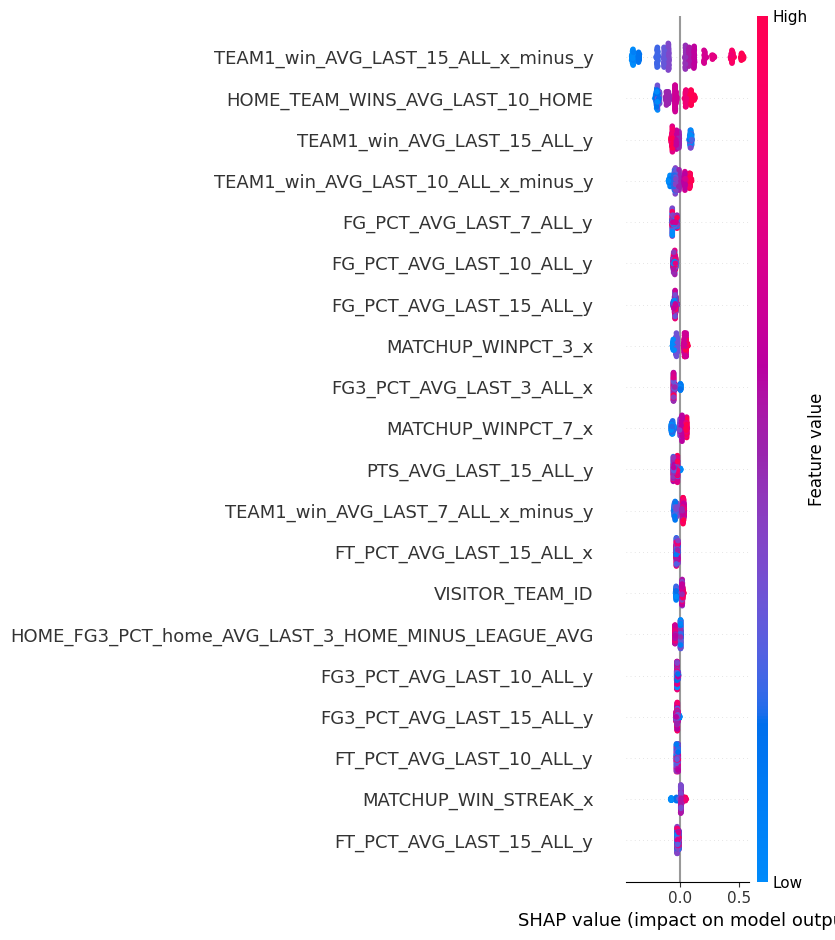

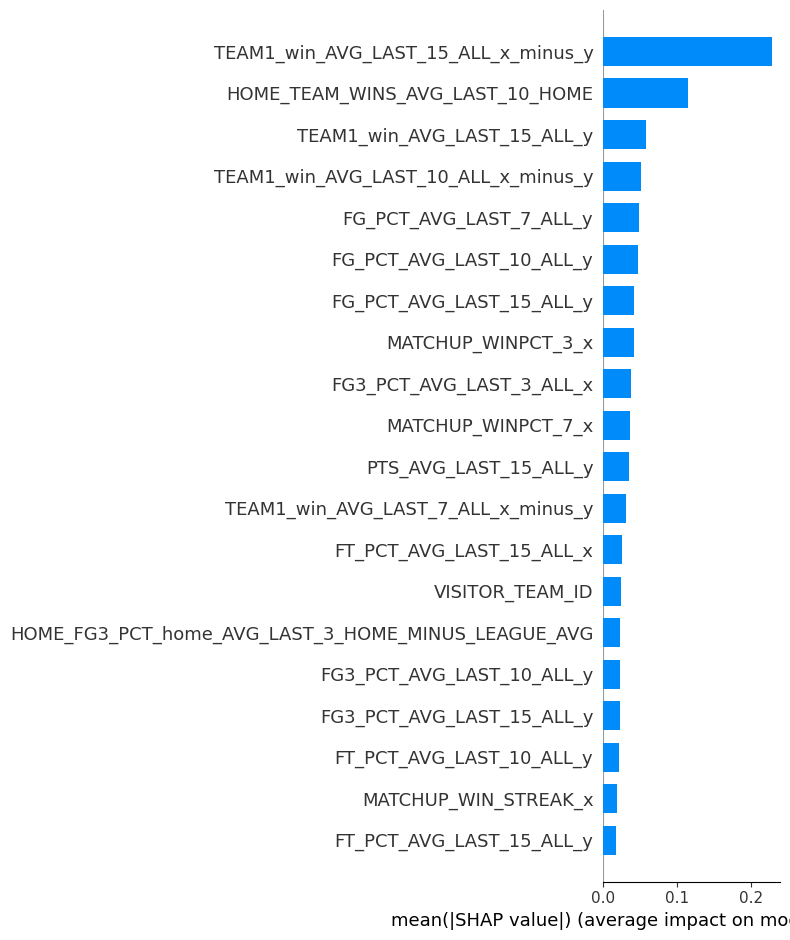

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285 entries, 88 to 202
Columns: 245 entries, GAME_DATE_EST to REB_AVG_LAST_15_ALL_x_minus_y
dtypes: datetime64[ns](1), float16(222), int32(1), int8(21)
memory usage: 135.0 KB
TEST1

Scores:

Accuracy Score: 0.6029411764705882
AUC Score: 0.580238726790451
Optimal Threshold: 0.49073887
              precision    recall  f1-score   support

           0       0.64      0.72      0.67        78
           1       0.54      0.45      0.49        58

    accuracy                           0.60       136
   macro avg       0.59      0.58      0.58       136
weighted avg       0.60      0.60      0.60       136



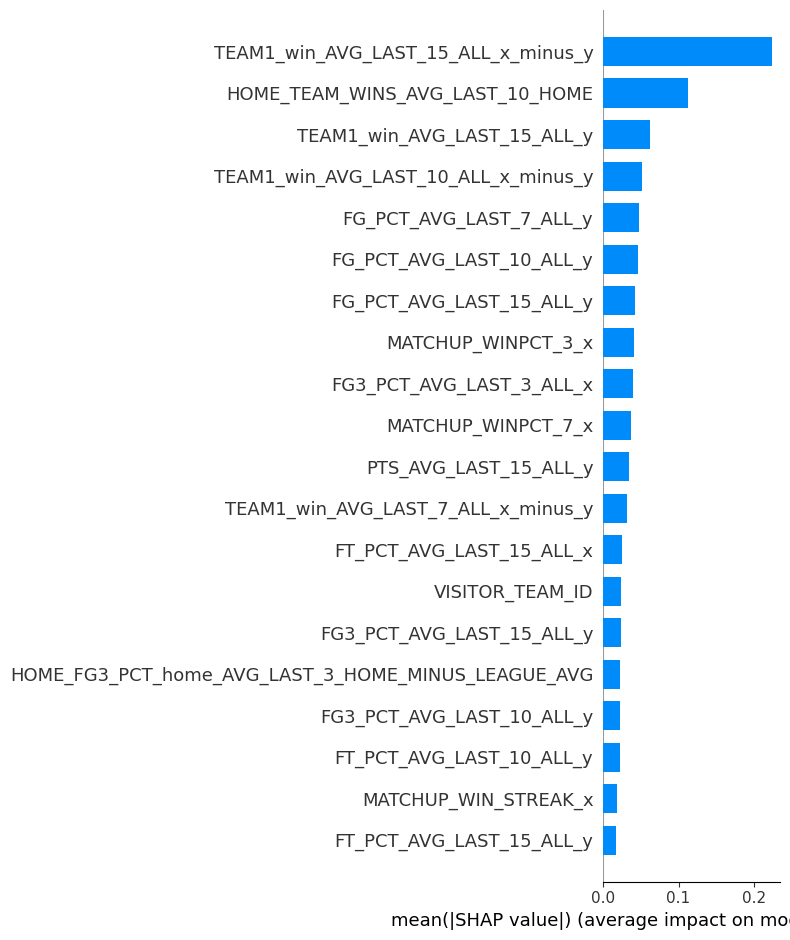

TEST2

Scores:

Accuracy Score: 0.6308724832214765
AUC Score: 0.6702898550724637
Optimal Threshold: 0.4526263
              precision    recall  f1-score   support

           0       0.72      0.65      0.69        92
           1       0.52      0.60      0.55        57

    accuracy                           0.63       149
   macro avg       0.62      0.62      0.62       149
weighted avg       0.64      0.63      0.63       149



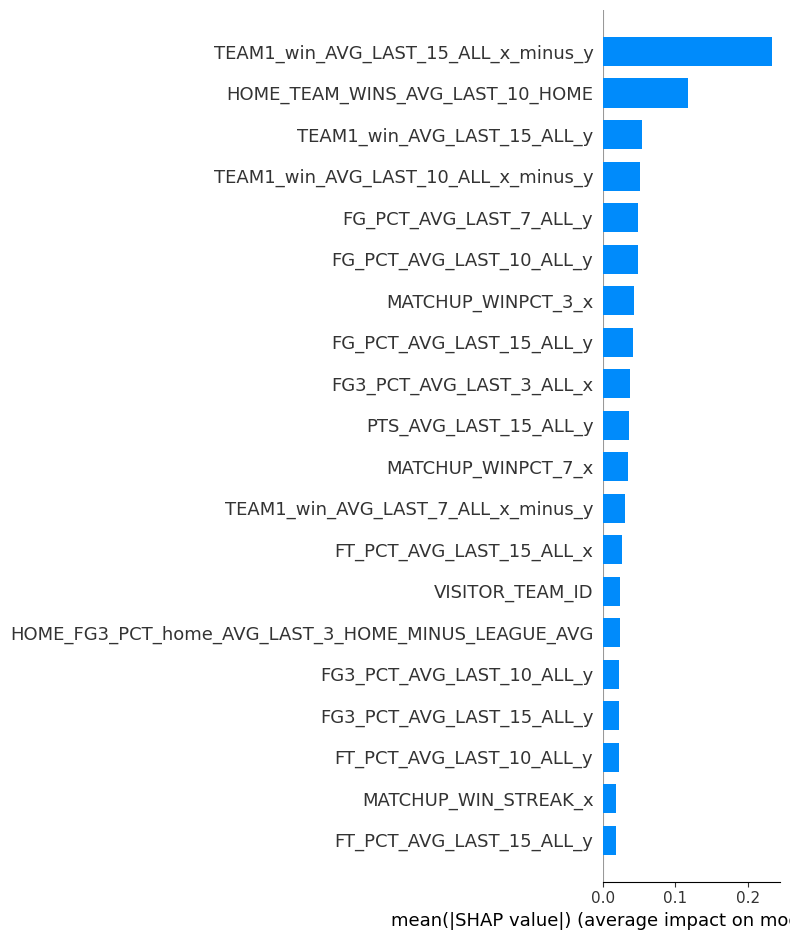

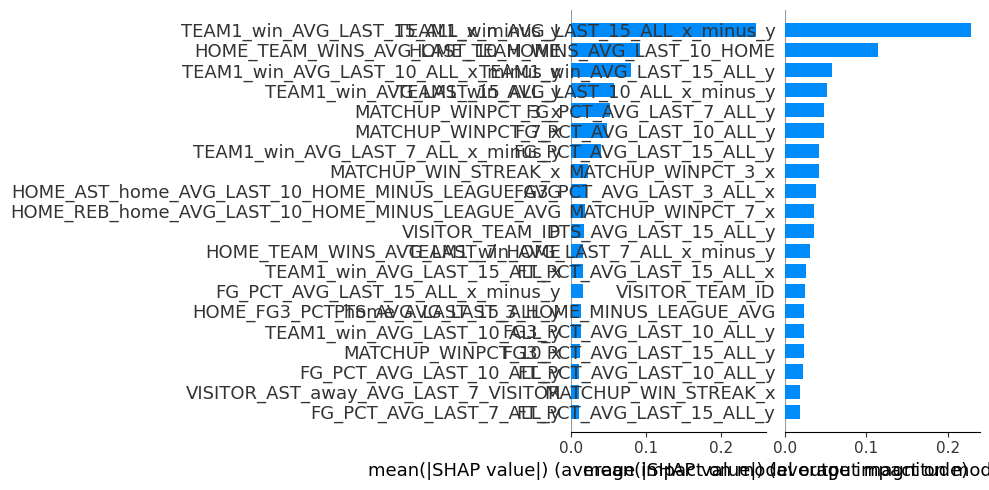

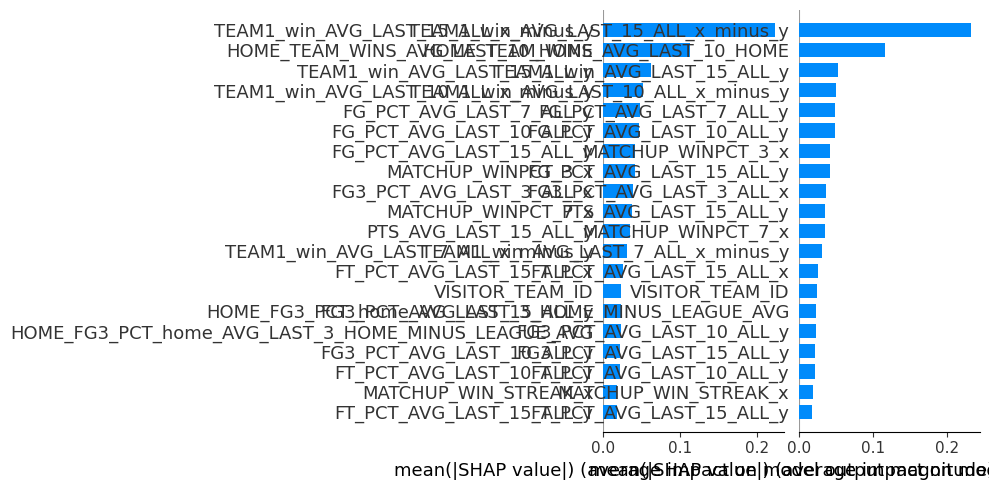

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 85 operations to synchronize with Neptune. Do not kill this process.
All 85 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/cmunch1/nba-prediction/e/NBAP-151


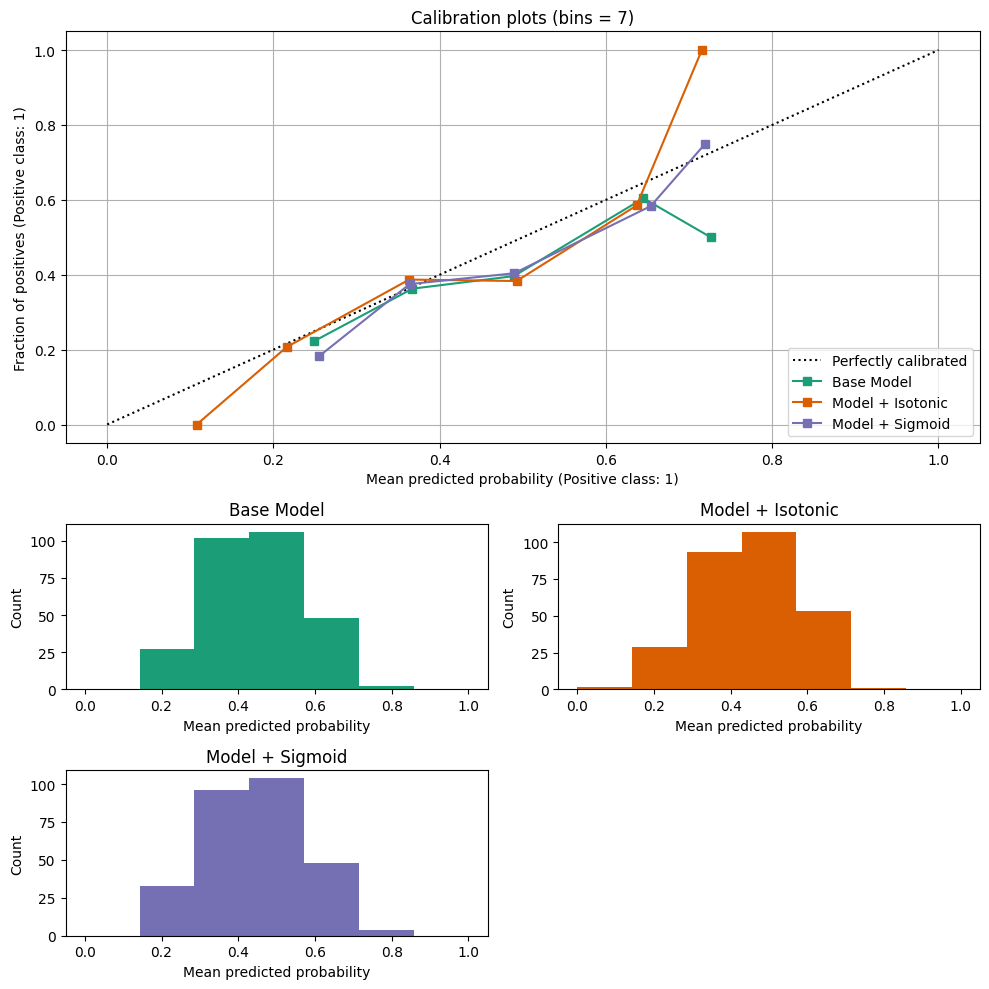

Best calibrated model is:  Model + Isotonic


In [6]:
%run 07_model_testing.ipynb


**Save to Model Registry**



In [7]:
# read in train_predictions to create model schema
train = pd.read_csv(DATAPATH / "train_predictions.csv")
target = train['TARGET']
drop_columns = ['TARGET', 'PredictionPct', 'Prediction']
train = train.drop(columns=drop_columns)

input_schema = Schema(train)
output_schema = Schema(target)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)
model_schema.to_dict()

# read in model meta_data from training run
with open('model_data.json', 'rb') as fp:
    model_data = json.load(fp)
    

# log back in to hopsworks.ai. Hyperparameter tuning may take hours.
project = hopsworks.login(api_key_value=HOPSWORKS_API_KEY)
mr = project.get_model_registry()

model = mr.sklearn.create_model(
    name = model_data['model_name'],
    metrics = model_data['metrics'],
    description = (model_data['model_name'] + ", calibration_method: " + model_data['calibration_method'] + ", brier_loss: " + str(model_data['brier_loss'])), 
    model_schema = model_schema
)
model.save('model.pkl')


Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/3350
Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/3350/models/xgboost/12


Model(name: 'xgboost', version: 12)